In [5]:
import pandas as pd
import numpy as np
import warnings
from sklearn.datasets import make_classification
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action='ignore')

In [3]:
import pandas as pd
import numpy as np
from typing import Union, List
'''
TODO
1) addr_state 변수 설정해야한다
2) 결측치에서 'acc_open_past_24mths', 'avg_cur_bal': 확인필요
'''
class Preprocessor:
    def __init__(self):
        self.file_path = ""
        self.folder_path = ""
        self.df = pd.DataFrame()
    
    def __init__(self, data_file_path:str="", folder_path:str=""):
        self.file_path = data_file_path
        self.folder_path = folder_path
        self.df = pd.DataFrame()
        
    def load_origin_file(self, file_path:str)->None:
        if file_path!="":
            self.file_path = file_path
        self.df = pd.read_csv(self.file_path)
        
    def drop_columns(self, drop_columns_file_path:str = "drop_columns_0402.txt")->None:
        with open(drop_columns_file_path, mode='r') as f:
            drop_fields = f.readlines()
            drop_fields = [drop_field.strip('\n') for drop_field in drop_fields]
        self.df.drop(columns=drop_fields, inplace=True)
    
    def __preprocess_target_variable(self, target_variable:str="loan_status")->None:
        # loan_status가 "current", "issued", "policy" 인 행을 필터링하여 삭제
        modified_df = self.df[~self.df[target_variable].isin(['Current', 'Issued', 'Does not meet the credit policy. Status:Fully Paid', 'Does not meet the credit policy. Status:Charged Off'])]
        # risk = 1, safe = 0 으로 처리
        modified_df.loc[modified_df['loan_status'].isin(['Fully Paid', 'In Grace Period']), 'loan_status'] = 0
        modified_df.loc[modified_df['loan_status'].isin(['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']), 'loan_status'] = 1
        modified_df['loan_status'] = modified_df['loan_status'].astype('int')
        self.df = modified_df
        
    ## 5. 데이터 처리용 함수
    def __delete_suffix(self, term:str)->int:
        '''첫 단어만을 저장하는 함수'''
        term = term.strip().split()[0]
        return int(term)

    def __delete_suffix_percentage(self, term:str)->float:
        '''%를 자르는 함수'''
        term = term.strip('%')
        return float(term)
    
    def __fill_na_with_value(self, columns:List[str], filling_value:Union[str, int])->None:
        '''
        df: dataframe to fill NA
        column_name : column name to change NA values
        filling_value : value type or just value to fill column's NA
        '''
        for column_name in columns:
            if filling_value=="mode":
                mode_value = self.df[column_name].mode()[0]
            elif filling_value=="median":
                mode_value = self.df[column_name].median()
            else:
                mode_value = filling_value
            self.df[column_name].fillna(mode_value, inplace=True)
        
    def __preprocessing_na(self)->None:
        '''
        'acc_open_past_24mths', 확인필요
        'avg_cur_bal', 확인필요
        '''
        ## 결측 처리
        # 결측 개수가 1천 건 이하인 경우는 해당 데이터(row) 삭제
        self.df.dropna(subset=['chargeoff_within_12_mths','collections_12_mths_ex_med','dti',
                                                'pub_rec_bankruptcies','revol_util','tax_liens'], inplace=True)
        
        # A1. 최빈값 대체
        self.__fill_na_with_value(columns=['mo_sin_old_il_acct', 'mths_since_recent_bc', 'mths_since_recent_inq', 'emp_length'], filling_value='mode')
        
        # A2. 중앙값 대체
        self.__fill_na_with_value(columns=['bc_open_to_buy'], filling_value='median')
        # B. 2015년 대체
        # is_after_2015 컬럼 생성. all_util 변수를 기준으로 사용
        self.df['is_after_2015'] = self.df['all_util'].apply(lambda x: 0 if pd.isnull(x) else 1)
        # 결측값을 0으로 채우기
        
        # C. 2012년 대체
        # is_after_2012 컬럼 생성. pct_tl_nvr_dlq 변수를 기준으로 사용
        self.df['is_after_2012'] = self.df['pct_tl_nvr_dlq'].apply(lambda x: 0 if pd.isnull(x) else 1)
        # D. 결측 0 대체
        self.__fill_na_with_value(columns=['annual_inc_joint','dti_joint','revol_bal_joint', 'open_acc_6m',
                                           'open_act_il', 'open_il_12m', 'open_il_24m', 'total_bal_il',
                                           'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_cu_tl', 'mths_since_rcnt_il',
                                           'tot_cur_bal', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op',
                                           'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_bc_sats', 'num_bc_tl',
                                           'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_il_tl',
                                           'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',
                                           'num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','tot_hi_cred_lim','total_bal_ex_mort',
                                           'total_bc_limit','total_il_high_credit_limit'], filling_value=0)
        
        
    def __convert_object_to_numeric(self, column_name:str)->pd.DataFrame:
        unique_values = sorted(self.df[column_name].unique())
        value_map = {value:index for index, value in enumerate(unique_values)}
        self.df[column_name] = self.df[column_name].apply(lambda x:value_map.get(x))
        return self.df
    
    def __convert_object_to_one_hot(self, column_name:str)->None:
        encoded = pd.get_dummies(self.df[column_name])
        self.df = pd.concat([self.df, encoded], axis=1)
        self.df.drop(column_name, axis=1, inplace=True)
        
    def __preprocessing_objects(self)->None:
        ## TODO : 'addr_state' 필드 해결하기
        # term
        self.df['term'] = self.df['term'].apply(self.__delete_suffix)
        # emp_length
        self.df['emp_length'] = self.df['emp_length'].apply(lambda x: x.replace(' years','').replace(' year','').replace('+','').replace('< 1', '0'))
        self.df['emp_length'] = self.df['emp_length'].astype(int)
        # revol_util
        self.df['revol_util'] = self.df['revol_util'].apply(self.__delete_suffix_percentage)
        self.df['int_rate'] = self.df['int_rate'].apply(self.__delete_suffix_percentage)
        ## numeric
        # application_type
        self.df = self.__convert_object_to_numeric('application_type')
        # sub_grade
        self.df = self.__convert_object_to_numeric('sub_grade')

        ## one-hot
        # home_ownership
        self.df['home_ownership'] = self.df['home_ownership'].replace(['ANY', 'OTHER', 'NONE'], 'OTHERS')
        self.__convert_object_to_one_hot('home_ownership')
        self.__purpose()
        # purpose
        self.__convert_object_to_one_hot('purpose')
        self.__verification_status()
        # verification_status
        # self.__convert_object_to_one_hot('verification_status')
        # addr_state : 해야함...
    def __purpose(self):
        self.df['purpose'] = self.df['purpose'].map({"small_business":"essential_purpose", 
                                                     "house":"essential_purpose", 
                                                     "moving":"essential_purpose",
                                                     "medical":"essential_purpose",
                                                     "renewable_energy":"essential_purpose",
                                                     "other":"essential_purpose",
                                                     "wedding":"optional_purpose",
                                                     "vacation":"optional_purpose",
                                                     "car":"optional_purpose",
                                                     "home_improvement":"optional_purpose",
                                                     "educational":"optional_purpose",
                                                     "debt_consolidation":"debt_consolidation",
                                                     "credit_card":"credit_card",})
    def __verification_status(self):
        self.df['verification_status'] = self.df['verification_status'].map({"Not Verified":False, 'Source Verified':True, 'Verified':True})

    def preprocess(self)->None:
        # loan_status 제외 모든 column이 결측치(na)인 행 제거 (1개 행 제거됨)
        self.df.dropna(subset=self.df.columns.difference(['loan_status']),how='all', inplace=True)
        self.__preprocess_target_variable()
        # 결측치 제거
        self.__preprocessing_na()
        ## object 처리하기
        self.__preprocessing_objects()
        # index 재설정
        self.df.reset_index(drop=True, inplace=True)
        self.df.dropna(subset=self.df.columns.difference(['loan_status']),how='all', inplace=True)
        
    def get_df(self)->pd.DataFrame:
        return self.df

In [6]:
p = Preprocessor()
# lending_club_2020_train.csv 파일이 있는 절대 경로 혹은 상대 경로를 명시해주세요
p.load_origin_file(file_path="data/lending_club_2020_train.csv")
# drop_columns_0410.txt 파일의 위치를 명시해주세요
p.drop_columns(drop_columns_file_path='texts/drop_columns_0411.txt')
# preprocess를 돌리면, addr_state를 제외한 object field 및, na(결측치) 처리됩니다.
p.preprocess()

In [6]:
origin_df = pd.read_csv("data/lending_club_2020_train.csv")

In [18]:
def delete_suffix_percentage(term:str)->float:
    '''%를 자르는 함수'''
    term = term.strip('%')
    return float(term)

In [19]:
origin_df['int_rate_number'] = origin_df['int_rate'].astype(str).apply(delete_suffix_percentage)
origin_df['int_rate_number']

0           7.97
1          14.47
2          24.99
3           9.93
4          16.40
           ...  
1755290    19.99
1755291     6.68
1755292    14.33
1755293     7.35
1755294    13.49
Name: int_rate_number, Length: 1755295, dtype: float64

In [21]:
np.average((origin_df[origin_df['loan_status']=='Charged Off']['total_rec_prncp']+origin_df[origin_df['loan_status']=='Charged Off']['total_rec_int'])/(origin_df[origin_df['loan_status']=='Charged Off']['loan_amnt']*(1+origin_df[origin_df['loan_status']=='Charged Off']['int_rate_number']/100)))

0.41506332575833793

In [12]:
condition = (origin_df['loan_status'] != 'Current') & \
            (origin_df['loan_status'] != 'Issued') & \
            (origin_df['loan_status'] != 'Does not meet the credit policy. Status:Fully Paid') & \
            (origin_df['loan_status'] != 'Does not meet the credit policy. Status:Charged Off')

filtered_df = origin_df[condition]
filtered_df['loan_status'].value_counts()*100/len(filtered_df)

loan_status
Fully Paid            79.258088
Charged Off           19.173725
Late (31-120 days)     0.867981
In Grace Period        0.533579
Late (16-30 days)      0.142899
Default                0.023640
Name: count, dtype: float64

In [7]:
## 여기 뭔가가 이상함,,,
df = p.get_df()


In [8]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,annual_inc,verification_status,loan_status,dti,...,is_after_2015,is_after_2012,MORTGAGE,OTHERS,OWN,RENT,credit_card,debt_consolidation,essential_purpose,optional_purpose
0,6000.0,36,7.97,187.94,4,2,45000.0,True,0,8.67,...,1,1,True,False,False,False,False,True,False,False
1,23200.0,60,24.99,680.82,23,10,110000.0,True,1,34.70,...,1,1,True,False,False,False,False,True,False,False
2,16000.0,36,7.07,494.55,1,10,65000.0,False,1,17.74,...,1,1,True,False,False,False,False,False,False,True
3,4500.0,36,10.42,146.10,7,5,50000.0,False,0,6.99,...,1,1,True,False,False,False,False,False,False,True
4,20000.0,36,9.99,645.25,7,10,60000.0,True,0,28.94,...,0,1,True,False,False,False,True,False,False,False


In [15]:
with open("final_drop.txt", mode='r') as f:
    drop_columns = [line.strip() for line in f.readlines()]
drop_columns

['open_acc',
 'num_sats',
 'total_acc',
 'num_actv_rev_tl',
 'num_rev_accts',
 'num_op_rev_tl',
 'tot_hi_cred_lim',
 'num_il_tl',
 'total_bal_ex_mort',
 'num_bc_tl',
 'num_actv_bc_tl',
 'num_bc_sats',
 'total_bc_limit',
 'total_rev_hi_lim',
 'total_il_high_credit_limit',
 'bc_open_to_buy',
 'revol_util',
 'mo_sin_old_il_acct',
 'all_util',
 'open_rv_12m',
 'num_tl_op_past_12m',
 'mo_sin_old_rev_tl_op',
 'total_bal_il',
 'open_act_il',
 'open_rv_24m',
 'open_il_24m',
 'tax_liens',
 'pub_rec_bankruptcies',
 'open_il_12m',
 'mort_acc',
 'mo_sin_rcnt_rev_tl_op',
 'open_acc_6m',
 'mo_sin_rcnt_tl',
 'max_bal_bc',
 'dti_joint',
 'mths_since_recent_inq',
 'annual_inc_joint',
 'mths_since_recent_bc',
 'revol_bal_joint',
 'num_tl_90g_dpd_24m',
 'mths_since_rcnt_il',
 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'total_cu_tl',
 'collections_12_mths_ex_med']

In [13]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'annual_inc', 'verification_status', 'loan_status', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'application_type', 'annual_inc_joint',
       'dti_joint', 'acc_now_delinq', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'total_cu_tl', 'bc_open_to_buy',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',

In [16]:
txt_set = set(drop_columns)
df_set = set(df.columns)
df_set-txt_set

{'MORTGAGE',
 'OTHERS',
 'OWN',
 'RENT',
 'acc_now_delinq',
 'annual_inc',
 'application_type',
 'chargeoff_within_12_mths',
 'credit_card',
 'debt_consolidation',
 'delinq_2yrs',
 'delinq_amnt',
 'dti',
 'emp_length',
 'essential_purpose',
 'fico_range_high',
 'fico_range_low',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'is_after_2012',
 'is_after_2015',
 'loan_amnt',
 'loan_status',
 'num_rev_tl_bal_gt_0',
 'num_tl_30dpd',
 'optional_purpose',
 'pct_tl_nvr_dlq',
 'pub_rec',
 'revol_bal',
 'sub_grade',
 'term',
 'tot_cur_bal',
 'verification_status'}

In [28]:
df.select_dtypes('object').columns

Index(['addr_state'], dtype='object')

In [29]:
df['loan_amnt_intallment_rate'] = df['loan_amnt']/df['installment']

아래는 RFECV 관련 코드입니다

In [30]:
df.to_csv('modified_train_0412.csv')

In [20]:
y_train = df['loan_status']
X_train = df.drop(columns=['addr_state', 'loan_status','acc_open_past_24mths', 'avg_cur_bal'])

'총상환원금'/'총상환이자' : loan_amnt/installment
'총상환원금'/'대출금액' : loan_amnt

In [21]:
X_train.shape

(1131682, 91)

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# PCA를 사용하여 데이터 차원을 축소합니다.
pca = PCA(n_components=90)  # 주성분을 90개로 선택
X_pca = pca.fit_transform(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_train, test_size=0.2, random_state=42)

In [6]:
# 학습시킬 모델 지정
estimator = LGBMClassifier(random_state=1111, n_estimators=100, learning_rate=0.1, verbose=-1)
# 한 step에 제거할 featrue 개수 및 cross validation fold 수 지정
selector = RFECV(estimator, step=1, cv = 5, min_features_to_select=20)
selector = selector.fit(X_train, y_train)

In [7]:
selected_columns = X_train.columns[selector.support_]
selected_columns

Index(['loan_amnt', 'term', 'sub_grade', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'inq_last_6mths', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'annual_inc_joint', 'dti_joint', 'tot_cur_bal', 'open_act_il',
       'open_il_24m', 'mths_since_rcnt_il', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'total_cu_tl', 'bc_open_to_buy',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl',
       'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit', 'revol_bal_joint', 'is_after_2015',
       'MORTGA

In [8]:
selector.support_.sum()

60

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

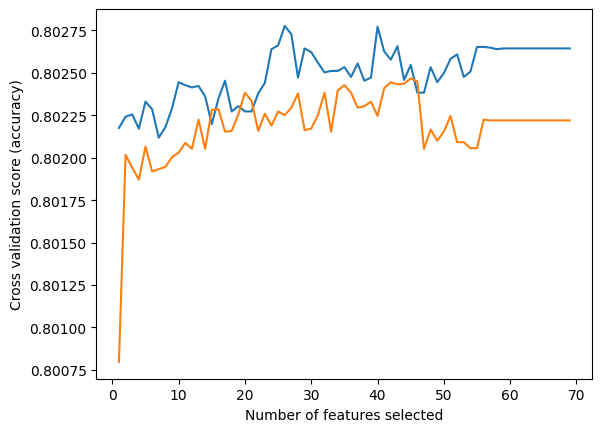

In [14]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
step=1
cv = 5
min_features_to_select=20
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['split0_test_score']) 
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['split1_test_score'])